# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Calibrate
4. Calculate lattice vectors
5. **Refine lattice vectors**
6. Calculate strain
7. Visualize strain maps

# Notebook 5: Refine lattice vectors

In this step the lattice vectors are refined by performing an interative, weighted fit to the measured Bragg peaks.

* For one, typical diffraction pattern:
    * Get the list of Bragg peaks
    * Determine the Bragg peak indices using the initial u,v guess
    * Iteratively: recalculate u,v values, recalculate Bragg peak indices
    * Get final u,v
* For each diffraction pattern:
    * Get the list of Bragg peaks
    * Ignore if there are insufficient peaks
    * Determine the Bragg peak indices using the initial u,v guess
    * Iteratively: recalculate u,v values, recalculate Bragg peak indices
    * Get final u,v

### Some formalism

At this point, we have the measured Bragg peak positions, and an initial guess at the lattice vectors.

Here, we'll
1. Index the observed Bragg peak positions, using our initial guess at the lattice vectors.
2. Using the indexed Bragg peak positions, we'll refine our of the lattice vectors for each diffraction pattern.

The approach here is to solve the system of linear equations:

\begin{align}
\mathbf{g}^{hk} = \mathbf{R}_0 + h\mathbf{u} + k\mathbf{v}
\end{align}

where $\mathbf{R}_0$ is the position of the unscattered beam, i.e. the origin of the diffraction plane, $\mathbf{u}$ and $\mathbf{v}$ are the reciprocal lattice vectors, $n$ and $m$ are integers, and $\mathbf{g}^{hk}$ is the measured position of the reciprocal lattice vector at index $(h,k)$.  Expanding in Cartesian coordinates gives

\begin{align*}
g^{hk}_x &= R_{0,x} + hu_x + kv_x  \\
g^{hk}_y &= R_{0,y} + hu_y + kv_y
\end{align*}

We'll use the matrix solver numpy.linalg.lstsq in each step.  For an equation of the form $\alpha = M\beta$, this solver finds $\beta$ given $\alpha$ and $M$.  We'll define these matrices slightly differently in each step here.

#### Step 1: Index the observed Bragg peaks

For indexing the Bragg peaks, its easiest to write

\begin{equation}
\begin{pmatrix}
         &   g^{hk}_x - R_{0,x}   &            \\
\cdots   &              &   \cdots   \\
         &   g^{hk}_y - R_{0,y}   &
\end{pmatrix}
=
\begin{pmatrix}
u_x   &   v_x   \\
u_y   &   v_y
\end{pmatrix}
\begin{pmatrix}
         &   h   &            \\
\cdots   &       &   \cdots   \\
         &   k   &
\end{pmatrix}
\end{equation}

which we'll notate $\alpha_1 = \beta_1 M_1$.  Here, $\alpha$ is the $2\times N$ matrix representing the $N$ detected Bragg peaks measure with respect to the unscattered beam position, $\beta$ is the $2\times2$ matrix containing the reciprocal lattice vectors, and $M$ is the $2\times N$ matrix of the Bragg peak indices.  

#### Step 2: Calculate the lattice vectors

In this step we'll calculate the lattice vectors separately at each diffraction pattern.  We'll allow the origin to shift slightly from one diffraction pattern to the next, so we'll need to slightly restructure the matrices.  We also want to solve for $\beta$ rather than $M$ now, so take the transpose of both sides and write the expression as

\begin{equation}
\begin{pmatrix}
&\vdots& \\
g^{hk}_x   & &   g^{hk}_y   \\
&\vdots&
\end{pmatrix}
=
\begin{pmatrix}
    &  \vdots  &       \\
1   &     h    &   k   \\
    &  \vdots  &
\end{pmatrix}
\begin{pmatrix}
R_{0,x}   &   R_{0,y}   \\
u_x   &   u_y   \\
v_x   &   v_y
\end{pmatrix}
\end{equation}

In this step, we'll let this last expression be represented by $\alpha = M\beta$.  Here, $\alpha$ is the $N\times 2$ matrix representing the $N$ detected Bragg peaks, $M$ is the $N\times 3$ matrix encoding the indexing of the Bragg peaks, and $\beta$ is the $3\times2$ matrix containing the reciprocal lattice vectors and the origin.  

Note, then, that the matrices in steps 1 and 2 differ in two ways; one superficial and one substantive. The first is that they are transposes of one another.  The second is that they latter matrices are written with an extra column (row) in $M$ ($\beta$) to allow for shifts in the position of the origin.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing

from py4DSTEM.file.datastructure import RealSlice, PointList
from py4DSTEM.file.readwrite import FileBrowser, read, append

In [7]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    deconvolution                       DiffractionSlice    
   2    deconvolution_1                     DiffractionSlice    
   3    deconvolution_shiftcorrected        DiffractionSlice    
   4    deconvolution_shiftcorrected_ellipsecorrectedDiffractionSlice    
   5    deconvolution_uncorrected           DiffractionSlice    
   6    diffractionslice_3                  DiffractionSlice    
   7    probe_kernel                        DiffractionSlice    
   8    DF_image                            RealSlice           
   9    DF_image_1                          RealSlice           
   10   diffraction_shifts                  RealSlice           
   11   diffraction_shifts_1                RealSlice           
   12   diffraction_shifts_2                RealSlice           
   13   realslice_0                         RealSlice           
   14   strain_m

In [8]:
# Load data

dc = browser.get_dataobject('datacube')
Bragg_peaks = browser.get_dataobject('shifted_Braggpeaks')
lattice_vectors = browser.get_dataobject('lattice_vectors_2')
deconvolution = browser.get_dataobject('deconvolution')
browser.close()

In [10]:
lattice_vectors.data

array([(-47.95902161, 27.1792637 ), ( 54.19673872, 95.14736329)],
      dtype=[('qx', '<f8'), ('qy', '<f8')])

### Index Bragg peaks from deconvolution

In [11]:
# Get beta, the lattice vector matrix
# Note that for the initial pass

R_0x,R_0y = np.unravel_index(np.argmax(gaussian_filter(deconvolution.data2D,2)),deconvolution.data2D.shape)

u_x = lattice_vectors.data['qx'][0]
u_y = lattice_vectors.data['qy'][0]
v_x = lattice_vectors.data['qx'][1]
v_y = lattice_vectors.data['qy'][1]

beta_1 = np.array([[u_x, v_x],[u_y, v_y]])

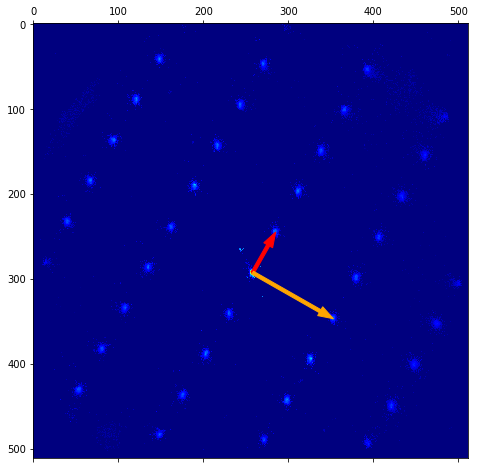

In [13]:
# Show deconvolition and lattice vectors

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(deconvolution.data2D**0.25,cmap='jet')
ax.arrow(R_0y,R_0x,u_y,u_x, color='red',width=4,length_includes_head=True)
ax.arrow(R_0y,R_0x,v_y,v_x, color='orange',width=4,length_includes_head=True)
plt.show()

In [14]:
# Find deconvolution peak positions

sigma = 2
maxNumPeaks = 40
minPeakSpacing = 40
minRelativeIntensity = 0.05   # Compare to either brightest or second brightest peak

deconvolution_smoothed = gaussian_filter(deconvolution.data2D,sigma)

maxima = py4DSTEM.process.utils.get_maximal_points(deconvolution_smoothed)

# Make deconvolution_peaks PointList with structured array datatype ('rx','ry','qx','qy','intensity')
coords = [('qx',float),('qy',float),('h',int),('k',int),('intensity',float)]
deconvolution_peaks = PointList(coordinates=coords, parentDataCube=dc)

max_point_indices_x, max_point_indices_y = np.nonzero(maxima)
point_intensities = deconvolution_smoothed[max_point_indices_x,max_point_indices_y]

length = len(point_intensities)
for i in range(length):
    new_point = (max_point_indices_x[i],max_point_indices_y[i],0,0,point_intensities[i])
    deconvolution_peaks.add_point(new_point)

# Order point list, keep only up to maxNumPeaks
numPeaks = min(maxNumPeaks,length)
deconvolution_peaks.sort(coordinate='intensity',order='descending')
deletePeaks = np.zeros(deconvolution_peaks.length, bool)
deletePeaks[numPeaks:] = True
deconvolution_peaks.remove_points(deletePeaks)         

# Remove peaks that are too close together
r2 = minPeakSpacing**2
deletePeaks = np.zeros(numPeaks,dtype=bool)
for i in range(numPeaks):
    if deletePeaks[i] == False:
        tooClose = ( (deconvolution_peaks.data['qx']-deconvolution_peaks.data['qx'][i])**2 + \
                  (deconvolution_peaks.data['qy']-deconvolution_peaks.data['qy'][i])**2 ) < r2
        tooClose[:i+1] = False
        deletePeaks[tooClose] = True
deconvolution_peaks.remove_points(deletePeaks)

# Remove peaks below minRelativeIntensity threshold
#deletemask = deconvolution_peaks.data['intensity']/max(deconvolution_peaks.data['intensity']) < minRelativeIntensity  # Compare to brightest peak
deletemask = deconvolution_peaks.data['intensity']/deconvolution_peaks.data['intensity'][1] < minRelativeIntensity     # Compare to second brightest peak
deconvolution_peaks.remove_points(deletemask)

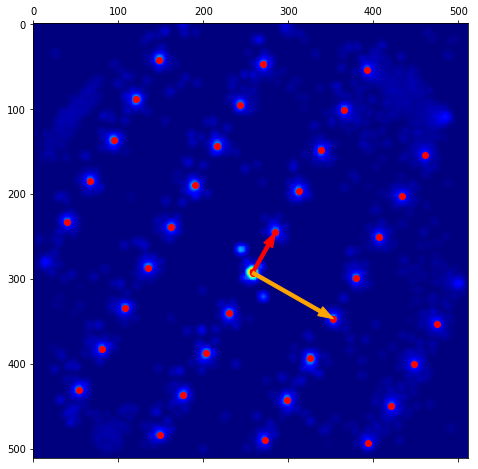

In [16]:
# Show

fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(deconvolution_smoothed**.25,cmap='jet')
ax.scatter(deconvolution_peaks.data['qy'],deconvolution_peaks.data['qx'],color='r')
ax.arrow(R_0y,R_0x,u_y,u_x, color='red',width=4,length_includes_head=True)
ax.arrow(R_0y,R_0x,v_y,v_x, color='orange',width=4,length_includes_head=True)
plt.show()

In [24]:
# Get alpha, the matrix of measured beam positions
# Here, we measure alpha with respect to the central beam position

x = deconvolution_peaks.data['qx'].reshape(deconvolution_peaks.length,1) - R_0x
y = deconvolution_peaks.data['qy'].reshape(deconvolution_peaks.length,1) - R_0y
alpha_1 = np.hstack((y,x)).T

In [25]:
# Calculate M, the matrix of peak indices

M_1 = lstsq(beta_1, alpha_1,rcond=None)[0].T
M_1 = np.round(M_1)

# Store indices and positions
for i in range(deconvolution_peaks.length):
    deconvolution_peaks.data['h'][i] = int(M_1[i,0])
    deconvolution_peaks.data['k'][i] = int(M_1[i,1])

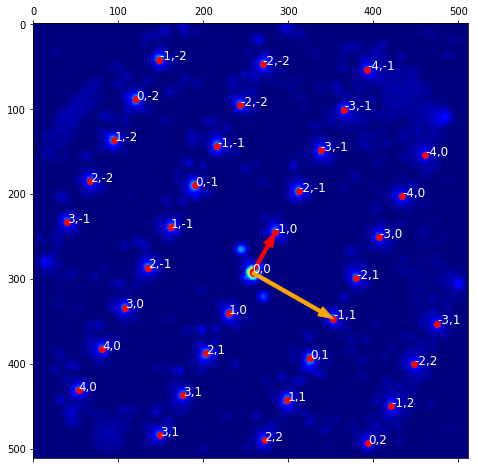

In [26]:
# Show
fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(deconvolution_smoothed**.25,cmap='jet')
ax.scatter(deconvolution_peaks.data['qy'],deconvolution_peaks.data['qx'],color='r')
ax.arrow(R_0y,R_0x,u_y,u_x, color='red',width=4,length_includes_head=True)
ax.arrow(R_0y,R_0x,v_y,v_x, color='orange',width=4,length_includes_head=True)
for i in range(deconvolution_peaks.length):
    ax.text(deconvolution_peaks.data['qy'][i],deconvolution_peaks.data['qx'][i],
            '{},{}'.format(deconvolution_peaks.data['h'][i],deconvolution_peaks.data['k'][i]),
            color='w',size=12)
plt.show()

### Single Diffraction Pattern

In [11]:
# Select DP, get the Bragg peaks for this DP, filter low intensity peaks

rx,ry = 5,25

Bragg_peaks_current_DP = Bragg_peaks.get_pointlist(rx,ry)

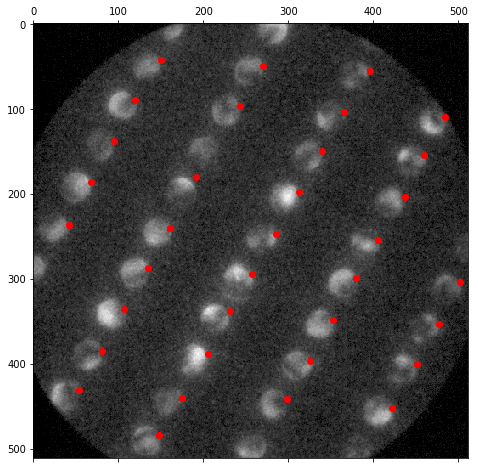

In [12]:
# Show

DP = dc.data4D[rx,ry,:,:]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP**.5)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
plt.show()

In [13]:
# Get Bragg peak indices

maxPeakSpacing = 40

h = np.zeros(Bragg_peaks_current_DP.length,dtype=int)
k = np.zeros(Bragg_peaks_current_DP.length,dtype=int)
deletemask = np.zeros(Bragg_peaks_current_DP.length,dtype=bool)
for i in range(Bragg_peaks_current_DP.length):
    r2 = (Bragg_peaks_current_DP.data['qx'][i] - deconvolution_peaks.data['qx'])**2 + \
         (Bragg_peaks_current_DP.data['qy'][i] - deconvolution_peaks.data['qy'])**2
    ind = np.argmin(r2)
    h[i] = deconvolution_peaks.data['h'][ind]
    k[i] = deconvolution_peaks.data['k'][ind]
    if r2[ind] > maxPeakSpacing**2:
        deletemask[i] = True
Bragg_peaks_current_DP.remove_points(deletemask)
h = np.delete(h,deletemask.nonzero()[0])
k = np.delete(k,deletemask.nonzero()[0])

In [14]:
# Make M, the matrix of (h,k) indices

M = np.vstack((np.ones_like(h,dtype=int),h,k)).T

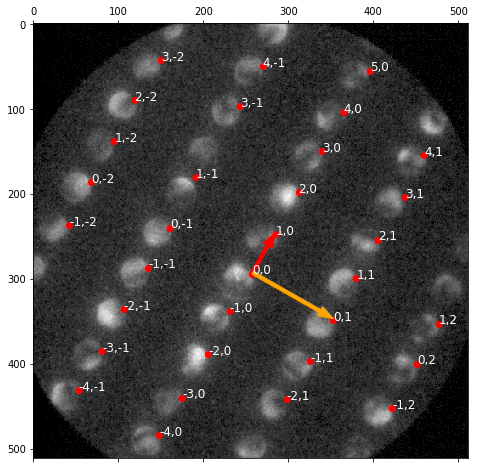

In [15]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP**.5)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(R_0y,R_0x,u_x,u_y, color='red',width=4,length_includes_head=True)
ax.arrow(R_0y,R_0x,v_x,v_y, color='orange',width=4,length_includes_head=True)
for i in range(Bragg_peaks_current_DP.length):
    ax.text(Bragg_peaks_current_DP.data['qy'][i],Bragg_peaks_current_DP.data['qx'][i],
            '{},{}'.format(int(M[i,1]),int(M[i,2])),color='w',size=12)
plt.show()

In [16]:
# Make alpha, the matrix of measured Bragg peak positions

x = Bragg_peaks_current_DP.data['qx'].reshape(Bragg_peaks_current_DP.length,1) - R_0x
y = Bragg_peaks_current_DP.data['qy'].reshape(Bragg_peaks_current_DP.length,1) - R_0y
alpha = np.hstack((y,x))

In [17]:
# Calculate beta, matrix of lattice vectors
# Weight according to cross correlation intensities

# Get weighted matrices
weights = Bragg_peaks_current_DP.data['intensity']
weighted_M = M*np.sqrt(weights[:,np.newaxis])
weighted_alpha = alpha*np.sqrt(weights[:,np.newaxis])

# Solve for lattice vectors (beta)
beta = lstsq(weighted_M, weighted_alpha,rcond=None)[0]

u_x, u_y = beta[1,0],beta[1,1]
v_x, v_y = beta[2,0],beta[2,1]

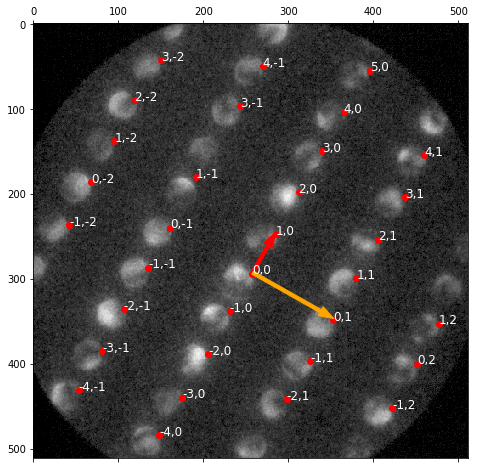

In [18]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP**.5)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(R_0y,R_0x,u_x,u_y, color='red',width=4,length_includes_head=True)
ax.arrow(R_0y,R_0x,v_x,v_y, color='orange',width=4,length_includes_head=True)
for i in range(Bragg_peaks_current_DP.length):
    ax.text(Bragg_peaks_current_DP.data['qy'][i],Bragg_peaks_current_DP.data['qx'][i],
            '{},{}'.format(int(M[i,1]),int(M[i,2])),color='w',size=12)
plt.show()

### All diffraction patterns

In [19]:
maxPeakSpacing = 40
minNumPeaks = 6

# Get unscattered beam position
R_0x,R_0y = np.unravel_index(np.argmax(deconvolution.data2D),deconvolution.data2D.shape)

# Make containers for outputs
slicelabels = ('ux','uy','vx','vy','fit_error')
uv_map = RealSlice(data=np.zeros((dc.R_Nx,dc.R_Ny,5)), slicelabels=slicelabels, name='uv_map')
DF_image = RealSlice(data=np.zeros((dc.R_Nx,dc.R_Ny)), name='DF_image')

for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        
        # Get Bragg peaks for scan position Rx,Ry 
        Bragg_peaks_current_DP = Bragg_peaks.get_pointlist(Rx,Ry)
        
        # Get Bragg peak indices
        h = np.zeros(Bragg_peaks_current_DP.length,dtype=int)
        k = np.zeros(Bragg_peaks_current_DP.length,dtype=int)
        deletemask = np.zeros(Bragg_peaks_current_DP.length,dtype=bool)
        for i in range(Bragg_peaks_current_DP.length):
            r2 = (Bragg_peaks_current_DP.data['qx'][i] - deconvolution_peaks.data['qx'])**2 + \
                 (Bragg_peaks_current_DP.data['qy'][i] - deconvolution_peaks.data['qy'])**2
            ind = np.argmin(r2)
            h[i] = deconvolution_peaks.data['h'][ind]
            k[i] = deconvolution_peaks.data['k'][ind]
            if r2[ind] > maxPeakSpacing**2:
                deletemask[i] = True
        Bragg_peaks_current_DP.remove_points(deletemask)
        h = np.delete(h,deletemask.nonzero()[0])
        k = np.delete(k,deletemask.nonzero()[0])
        
        # Check if minimum number of peaks are present
        if Bragg_peaks_current_DP.length > minNumPeaks:

            # Make M, the matrix of (h,k) indices
            M = np.vstack((np.ones_like(h,dtype=int),h,k)).T

            # Make alpha, the matrix of measured Bragg peak positions
            x = Bragg_peaks_current_DP.data['qx'].reshape(Bragg_peaks_current_DP.length,1) - R_0x
            y = Bragg_peaks_current_DP.data['qy'].reshape(Bragg_peaks_current_DP.length,1) - R_0y
            alpha = np.hstack((y,x))

            # Get weighted matrices
            weights = Bragg_peaks_current_DP.data['intensity']
            weighted_M = M*np.sqrt(weights[:,np.newaxis])
            weighted_alpha = alpha*np.sqrt(weights[:,np.newaxis])

            # Solve for beta, matrix of lattice vectors
            beta = lstsq(weighted_M, weighted_alpha,rcond=None)[0]
            u_x, u_y = beta[1,0],beta[1,1]
            v_x, v_y = beta[2,0],beta[2,1]

            # Calculate the error
            alpha_calculated = np.matmul(M, beta)
            fit_error = np.sqrt(np.sum((alpha - alpha_calculated)**2,axis=1))
            weighted_fit_error = np.sum(fit_error*weights)/np.sum(weights)

            # Store data
            uv_map.data2D['ux'][Rx,Ry] = u_x
            uv_map.data2D['uy'][Rx,Ry] = u_y
            uv_map.data2D['vx'][Rx,Ry] = v_x
            uv_map.data2D['vy'][Rx,Ry] = v_y
            uv_map.data2D['fit_error'][Rx,Ry] = weighted_fit_error
            DF_image.data2D[Rx,Ry] = np.sum(Bragg_peaks_current_DP.data['intensity'][1:])

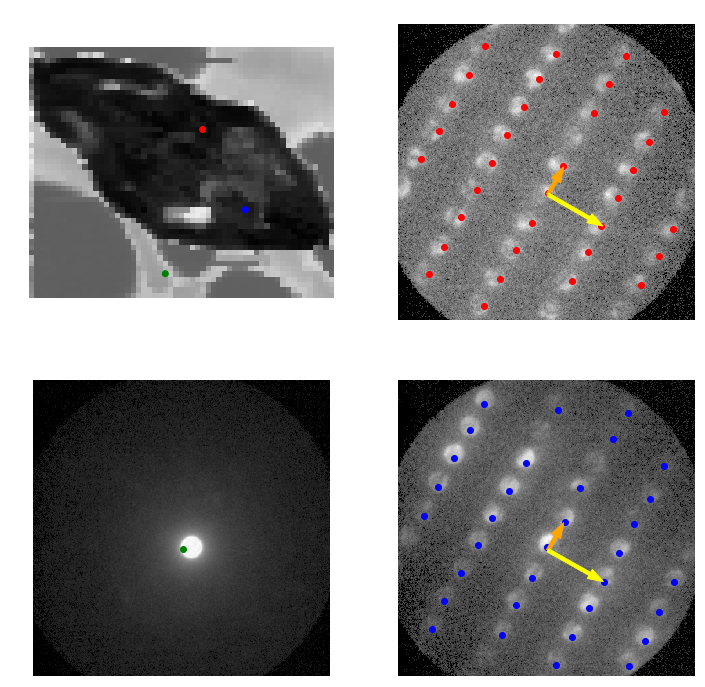

In [20]:
# Show lattice vectors for a few DPs

xs=(15,42,30)
ys=(32,25,40)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Bragg_peaks.get_pointlist(xs[0],ys[0])
peaks1 = Bragg_peaks.get_pointlist(xs[1],ys[1])
peaks2 = Bragg_peaks.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r')
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g')
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b')

if (uv_map.data2D['ux'][xs[0],ys[0]]!=0) and (uv_map.data2D['uy'][xs[0],ys[0]]!=0):
    ax12.arrow(R_0y,R_0x,uv_map.data2D['ux'][xs[0],ys[0]],uv_map.data2D['uy'][xs[0],ys[0]], color='orange',width=6,length_includes_head=True)
    ax12.arrow(R_0y,R_0x,uv_map.data2D['vx'][xs[0],ys[0]],uv_map.data2D['vy'][xs[0],ys[0]], color='yellow',width=6,length_includes_head=True)
if (uv_map.data2D['ux'][xs[1],ys[1]]!=0) and (uv_map.data2D['uy'][xs[1],ys[1]]!=0):
    ax21.arrow(R_0y,R_0x,uv_map.data2D['ux'][xs[1],ys[1]],uv_map.data2D['uy'][xs[1],ys[1]], color='orange',width=6,length_includes_head=True)
    ax21.arrow(R_0y,R_0x,uv_map.data2D['vx'][xs[1],ys[1]],uv_map.data2D['vy'][xs[1],ys[1]], color='yellow',width=6,length_includes_head=True)
if (uv_map.data2D['ux'][xs[2],ys[2]]!=0) and (uv_map.data2D['uy'][xs[2],ys[2]]!=0):
    ax22.arrow(R_0y,R_0x,uv_map.data2D['ux'][xs[2],ys[2]],uv_map.data2D['uy'][xs[2],ys[2]], color='orange',width=6,length_includes_head=True)
    ax22.arrow(R_0y,R_0x,uv_map.data2D['vx'][xs[2],ys[2]],uv_map.data2D['vy'][xs[2],ys[2]], color='yellow',width=6,length_includes_head=True)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

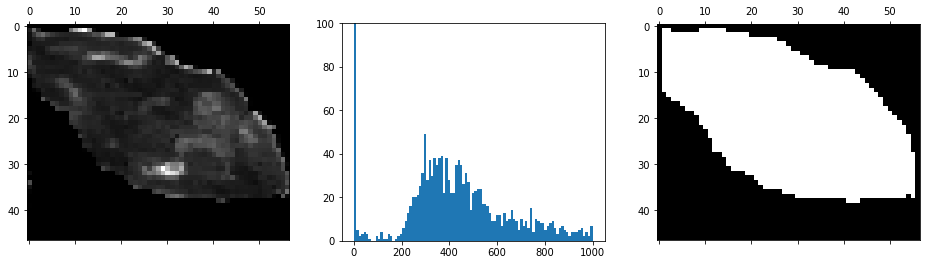

In [21]:
# Make a mask from the virtual dark-field image

mask = (DF_image.data2D>0)
mask = binary_closing(mask)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
ax1.matshow(DF_image.data2D)
ax2.hist(DF_image.data2D.ravel(),bins=np.linspace(0,1000,100))
ax2.set_ylim([0,100])
ax3.matshow(mask)
plt.show()

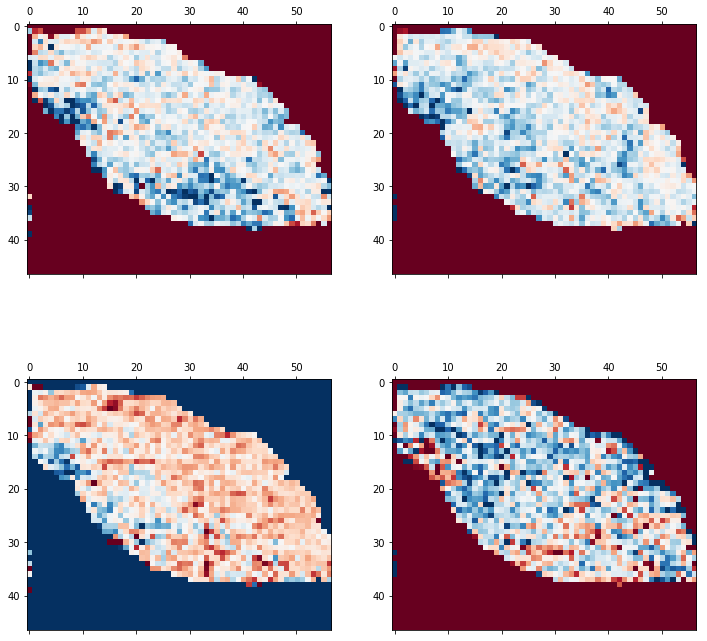

In [22]:
# Plot uncalibrated strains

n_stds = .3

u_lengths = np.sqrt(uv_map.data2D['ux']**2 + uv_map.data2D['uy']**2)
v_lengths = np.sqrt(uv_map.data2D['vx']**2 + uv_map.data2D['vy']**2)
u_length_ave, u_length_std = np.average(u_lengths[mask]), np.std(u_lengths[mask])
v_length_ave, v_length_std = np.average(v_lengths[mask]), np.std(v_lengths[mask])

u_angles = np.angle(uv_map.data2D['ux'] + 1j*uv_map.data2D['uy'])
v_angles = np.angle(uv_map.data2D['vx'] + 1j*uv_map.data2D['vy'])
u_angle_ave, u_angle_std = np.average(u_angles[mask]), np.std(u_angles[mask])
v_angle_ave, v_angle_std = np.average(v_angles[mask]), np.std(v_angles[mask])

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(u_lengths, vmin=u_length_ave-n_stds*u_length_std, vmax=u_length_ave+n_stds*u_length_std, cmap="RdBu")
ax12.matshow(v_lengths, vmin=v_length_ave-n_stds*v_length_std, vmax=v_length_ave+n_stds*v_length_std, cmap="RdBu")
ax21.matshow(u_angles, vmin=u_angle_ave-n_stds*u_angle_std, vmax=u_angle_ave+n_stds*u_angle_std, cmap="RdBu")
ax22.matshow(v_angles, vmin=v_angle_ave-n_stds*v_angle_std, vmax=v_angle_ave+n_stds*v_angle_std, cmap="RdBu")
plt.show()

/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


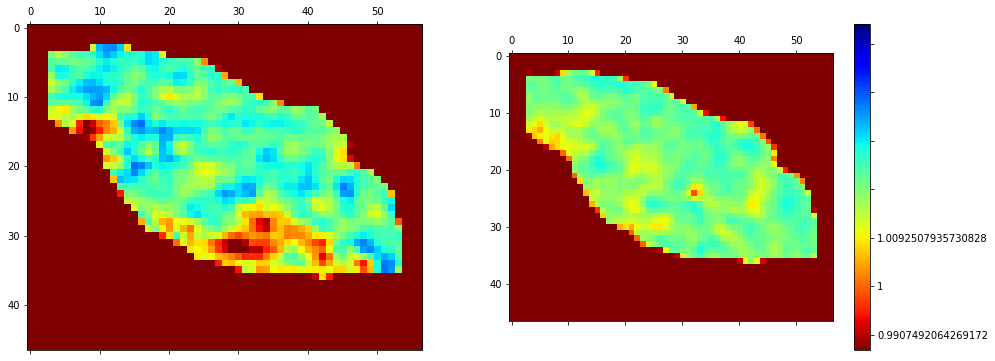

In [23]:
# Plot inverse u,v vector length with guassian blur

sigma=.8
n_stds = 1.5

u_length_inv = np.where(mask & (u_lengths != 0), 1./u_lengths, 0)
v_length_inv = np.where(mask & (v_lengths != 0), 1./v_lengths, 0)

u_lengthinv_ave, u_lengthinv_std = np.average(u_length_inv[u_length_inv!=0]), np.std(u_length_inv[u_length_inv!=0])
v_lengthinv_ave, v_lengthinv_std = np.average(v_length_inv[v_length_inv!=0]), np.std(v_length_inv[v_length_inv!=0])
std = max(u_lengthinv_std,v_lengthinv_std)
u_minval = u_lengthinv_ave-n_stds*std
u_maxval = u_lengthinv_ave+n_stds*std
v_minval = v_lengthinv_ave-n_stds*std
v_maxval = v_lengthinv_ave+n_stds*std

u_length_filt = gaussian_filter(u_length_inv,sigma)
v_length_filt = gaussian_filter(v_length_inv,sigma)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
cax1 = ax1.matshow(u_length_filt, vmin=u_minval, vmax=u_maxval, cmap="jet_r")
cax2 = ax2.matshow(v_length_filt, vmin=v_minval, vmax=v_maxval, cmap="jet_r")

cbar = fig.colorbar(cax1)
cbar.ax.set_yticklabels(['{}'.format(u_minval/u_lengthinv_ave), '{}'.format(1), '{}'.format(u_maxval/u_lengthinv_ave)])  # vertically oriented colorbar

plt.show()

### Save lattice vector maps

In [24]:
# Append to processing file

dataobjects = [uv_map, DF_image]

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(dataobjects, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
